<a href="https://colab.research.google.com/github/banno-0720/Deep-Learning-Projects/blob/main/Trashify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Overview

Trashify = using ML to incentivize people to pick up trash in their local area

We'll start with a collection of images with bounding box files as our dataset, fine-tune an existing computer vision model to detect items in an image and then share our model as a demo others can use.

TK image - update cover image for object detection
<!-- <figure style="text-align: center;">
    <!-- figtemplate -->
    <img src="https://huggingface.co/datasets/mrdbourke/learn-hf-images/resolve/main/learn-hf-text-classification/00-project-food-not-food-overview.png"
     alt="Project overview image for 'Food Not Food' classification at Nutrify, a food app. The project involves building and deploying a binary text classification model to identify food-related text using Hugging Face Datasets, Transformers, and deploying with Hugging Face Hub/Spaces and Gradio. Examples include labels for 'A photo of sushi rolls on a white plate' (food), 'A serving of chicken curry in a blue bowl' (food), and 'A yellow tractor driving over a grassy hill' (not food). The process is visually depicted from data collection to model training and demo deployment."
     style="width: 100%; max-width: 900px; height: auto;"/>
     <figcaption>We're going to put on our internship hats and build a food not food text classification model using tools from the Hugging Face ecosystem.</figcaption>
</figure>

## 1.1 What we're going to build

We're going to be bulding Trashify 🚮, an **object detection model** which incentivises people to pick up trash in their local area by detecting `bin`, `trash`, `hand`.

If all three items are detected, a person gets +1 point!

For example, say you were going for a walk around your neighbourhood and took a photo of yourself picking up a piece (with your **hand** or **trash arm**) of **trash** and putting it in the **bin**, you would get a point.

With this object detection model, you could deploy it to an application which would automatically detect the target classes and then save the result to an online leaderboard.

The incentive would be to score the most points, in turn, picking up the most piecces of trash, in a given area.

More specifically, we're going to follow the following steps:

1. **[Data](https://huggingface.co/datasets/mrdbourke/trashify_manual_labelled_images): Problem defintion and dataset preparation** - Getting a dataset/setting up the problem space.
2. **[Model](https://huggingface.co/docs/transformers/en/model_doc/conditional_detr): Finding, training and evaluating a model** - Finding an object detection model suitable for our problem on Hugging Face and customizing it to our own dataset.
3. **[Demo](https://huggingface.co/spaces/mrdbourke/trashify_demo_v3): Creating a demo and put our model into the real world** - Sharing our trained model in a way others can access and use.

By the end of this project, you'll have a trained model and [demo on Hugging Face](https://huggingface.co/spaces/mrdbourke/trashify_demo_v3) you can share with others:

In [ ]:
from IPython.display import HTML

HTML("""
<iframe
	src="https://mrdbourke-trashify-demo-v3.hf.space"
	frameborder="0"
	width="850"
	height="850"
></iframe>
""")

## 1.2 What is object detection?

Object detection is the process of identifying and locating an item in an image.

Where *item* can mean almost anything.

For example:

* Detecting car **licence plates** in a video feed (videos are a series of images) for a parking lot entrance.
* Detecting **delivery people** walking towards your front door on a security camera.
* Detecting **defects** on a manufacturing line.
* Detecting [**pot holes** in the road](https://ieeexplore.ieee.org/abstract/document/9968423) so repair works can automatically be scheduled.
* Detecting **small pests (Varroa Mite)** on the bodies of bees.
* Detecting [**weeds** in a field](https://ai.meta.com/blog/pytorch-drives-next-gen-intelligent-farming-machines/) so you know what to remove and what to keep.

--

Examples of actual trash identification projects, see:

- Google using machine learning for trash identification — [https://sustainability.google/operating-sustainably/stories/circular-economy-marketplace/](https://sustainability.google/operating-sustainably/stories/circular-economy-marketplace/)
- Trashify website for identifying trash — [https://www.trashify.tech/](https://www.trashify.tech/)
- Waste management with deep learning — [https://www.sciencedirect.com/science/article/abs/pii/S0956053X23001915](https://www.sciencedirect.com/science/article/abs/pii/S0956053X23001915)
- Label Studio being used for labelling a trash dataset — [https://labelstud.io/blog/ameru-labeling-for-a-greener-world/](https://labelstud.io/blog/ameru-labeling-for-a-greener-world/)

**Image classification** deals with classifying an image as a whole into a single `class`, object detection endeavours to find the specific target item and *where* it is in an image.

One of the most common ways of showing where an item is in an image is by displaying a **bounding box** (a rectangle-like box around the target item).

An object detection model will often take an input image tensor in the shape `[3, 640, 640]` (`[colour_channels, height, width]`) and output a tensor in the form `[class_name, x_min, y_min, x_max, y_max]` or `[class_name, x1, y1, x2, y2]` (this is two ways to write the same example format, there are more formats, we'll see these below in @tbl-bbox-formats).

Where:

* `class_name` = The classification of the target item (e.g. `"car"`, `"person"`, `"banana"`, `"piece_of_trash"`, this could be almost anything).
* `x_min` = The `x` value of the top left corner of the box.
* `y_min` = The `y` value of the top left corner of the box.
* `x_max` = The `x` value of the bottom right corner of the box.
* `y_max` = The `y` value of the bottom right corner of the box.

## 1.3 Why train your own object detection models?

You can customize **pre-trained models** for object detection as well as API-powered models and LLMs such as [Gemini](https://ai.google.dev/gemini-api/docs/vision?lang=python#bbox), [LandingAI](https://landing.ai/agentic-object-detection) and [DINO-X](https://github.com/IDEA-Research/DINO-X-API).

Depending on your requirements, there are several pros and cons for using your own model versus using an API.

Training/fine-tuning your own model:

| Pros | Cons |
| :----- | :----- |
| **Control:** Full control over model lifecycle. | Can be complex to get setup. |
| No usage limits (aside from compute constraints). | Requires dedicated compute resources for training/inference. |
| Can train once and deploy everywhere/whenever you want (for example, Tesla deploying a model to all self-driving cars). | Requires maintenance over time to ensure performance remains up to par. |
| **Privacy:** Data can be kept in-house/app and doesn’t need to go to a third party. | Can require longer development cycles compared to using existing APIs. |
| **Speed:** Customizing a small model for a specific use case often means it runs much faster on local hardware, for example, modern object detection models can achieve 70-100+ FPS (frames per second) on modern GPU hardware. | |

Using a pre-built model API:

| Pros | Cons |
| :----- | :----- |
| **Ease of use:** often can be setup within a few lines of code. | If the model API goes down, your service goes down. |
| No maintenance of compute resources. | Data is required to be sent to a third-party for processing. |
| Access to the most advanced models. | The API may have usage limits per day/time period. |
| Can scale if usage increases. | Can be much slower than using dedicated models due to requiring an API call. |

For this project, we're going to focus on fine-tuning our own model.

## 1.4 Workflow we're going to follow

Start with data (or skip this step and go straight to a model) -> get/customize a model -> build and share a demo.

With this in mind, our motto is *data, model, demo!*

More specifically, we're going to follow the rough workflow of:

1. Create, preprocess and load data using [Hugging Face Datasets](https://huggingface.co/docs/datasets/index).
2. Define the model we'd like use with [`transformers.AutoModelForObjectDetection`](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoModelForObjectDetection) (or another similar model class).
3. Define training arguments (these are hyperparameters for our model) with [`transformers.TrainingArguments`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments).
4. Pass `TrainingArguments` from 3 and target datasets to an instance of [`transformers.Trainer`](https://huggingface.co/docs/transformers/en/main_classes/trainer).
5. Train the model by calling [`Trainer.train()`](https://huggingface.co/docs/transformers/v4.40.2/en/main_classes/trainer#transformers.Trainer.train).
6. Save the model (to our local machine or to the Hugging Face Hub).
7. Evaluate the trained model by making and inspecting predctions on the test data.
8. Turn the model into a shareable demo.

I say rough because machine learning projects are often non-linear in nature.

As in, because machine learning projects involve many experiments, they can kind of be all over the place.

But this worfklow will give us some good guidelines to follow.

<figure style="text-align: center; display: inline-block;">
    <!-- figtemplate -->
    <img src="https://huggingface.co/datasets/mrdbourke/learn-hf-images/resolve/main/learn-hf-text-classification/01-hugging-face-workflow.png"
     alt="The diagram shows the Hugging Face model development workflow, which includes the following steps: start with an idea or problem, get data ready (turn into tensors/create data splits), pick a pretrained model (to suit your problem), train/fine-tune the model on your custom data, evaluate the model, improve through experimentation, save and upload the fine-tuned model to the Hugging Face Hub, and turn your model into a shareable demo. Tools used in this workflow are Datasets/Tokenizers, Transformers/PEFT/Accelerate/timm, Hub/Spaces/Gradio, and Evaluate."
     style="width: 100%; max-width: 900px; height: auto;"/>
     <figcaption style="width: 100%; box-sizing: border-box;">A general Hugging Face workflow from idea to shared model and demo using tools from the Hugging Face ecosystem. You'll notice some of the steps don't match with our workflow outline above. This is because the text-based workflow outline above breaks some of the steps down for educational purposes. These kind of workflows are not set in stone and are more of guide than specific directions. See information on each of the tools in the <a href="https://huggingface.co">Hugging Face documentation</a>.</figcaption>
</figure>

# 2. Importing necessary libraries

If you're running on your local computer, be sure to check out the getting [setup guide](https://www.learnhuggingface.com/extras/setup) to make sure you have everything you need.

If you're using Google Colab, many of them the following libraries will be installed by default.

However, we'll have to install a few extras to get everything working.

We'll need to install the following libraries from the Hugging Face ecosystem:

* [`transformers`](https://huggingface.co/docs/transformers/en/installation) - comes pre-installed on Google Colab but if you're running on your local machine, you can install it via `pip install transformers`.
* [`datasets`](https://huggingface.co/docs/datasets/installation) - a library for accessing and manipulating datasets on and off the Hugging Face Hub, you can install it via `pip install datasets`.
* [`evaluate`](https://huggingface.co/docs/evaluate/installation) - a library for evaluating machine learning model performance with various metrics, you can install it via `pip install evaluate`.
* [`accelerate`](https://huggingface.co/docs/accelerate/basic_tutorials/install) - a library for training machine learning models faster, you can install it via `pip install accelerate`.
* [`gradio`](https://www.gradio.app/guides/quickstart#installation) - a library for creating interactive demos of machine learning models, you can install it via `pip install gradio`.

And the following library is not part of the Hugging Face ecosystem but it is helpful for evaluating our models:

* [`torchmetrics`](https://lightning.ai/docs/torchmetrics/stable/) - a library containing many evaluation metrics compatible with PyTorch/Transformers, you can install it via `pip install torchmetrics`.

We can also check the versions of our software with `package_name.__version__`.

In [ ]:
# Install/import dependencies (this is mostly for Google Colab, as the other dependences are available by default in Colab)
try:
  import datasets, evaluate, accelerate
  import gradio as gr
except ModuleNotFoundError:
  !pip install -U datasets evaluate accelerate gradio # -U stands for "upgrade" so we'll get the latest version by default
  import datasets, evaluate, accelerate
  import gradio as gr

import random

import numpy as np

import torch
import transformers

# Required for evaluation
# Can install with !pip install torchmetrics[detection]
import torchmetrics
import pycocotools

# Check versions (as long as you've got the following versions or higher, you should be good)
print(f"Using transformers version: {transformers.__version__}")
print(f"Using datasets version: {datasets.__version__}")
print(f"Using torch version: {torch.__version__}")
print(f"Using torchmetrics version: {torchmetrics.__version__}")

Using transformers version: 4.48.3
Using datasets version: 3.1.0
Using torch version: 2.6.0+cu124
Using torchmetrics version: 1.4.1


# 3. Getting a dataset

Okay, now we're got the required libraries, let's get a dataset.

The dataset you often determines the type of model you use as well as the quality of the outputs of that model.

Meaning, if you have a high quality dataset, chances are, your future model could also have high quality outputs.

It also means if your dataset is of poor quality, your model will likely also have poor quality outputs.

For an object detection problem, your dataset will likely come in the form of a group of images as well as a file with annotations belonging to those images.

For example, you might have the following setup:

```
folder_of_images/
    image_1.jpeg
    image_2.jpeg
    image_3.jpeg
annotations.json
```

Where the `annotations.json` contains details about the contains of each image:

```{.json filename="annotations.json"}
[
    {
        'image_path': 'image_1.jpeg',
        'image_id': 42,
        'annotations':
            {
                'file_name': ['image_1.jpeg'],
                'image_id': [42],
                'category_id': [1],
                'bbox': [
                            [360.20001220703125, 528.5, 177.1999969482422, 261.79998779296875],
                        ],
                'area': [46390.9609375]
            },
        'label_source': 'manual_prodigy_label',
        'image_source': 'manual_taken_photo'
    },

    ...(more labels down here)
]
```

Don't worry too much about the exact meaning of everything in the above `annotations.json` file for now (this is only one example, there are many different ways object detection information could be displayed).

The main point is that each target image is paired with an assosciated label.

Now like all good machine learning cooking shows, I've prepared a dataset from earlier.

TK image - dataset on Hugging Face

It's stored on Hugging Face Datasets (also called the Hugging Face Hub) under the name [`mrdbourke/trashify_manual_labelled_images`](https://huggingface.co/datasets/mrdbourke/trashify_manual_labelled_images).

This is a dataset I've collected manually by hand (yes, by picking up 1000+ pieces of trash and photographing it) as well as labelled by hand (by drawing boxes on each image with a labelling tool called [Prodigy](https://prodi.gy/features/computer-vision)).


## 3.1 Loading the dataset

To load a dataset stored on the Hugging Face Hub we can use the [`datasets.load_dataset(path=NAME_OR_PATH_OF_DATASET)`](https://huggingface.co/docs/datasets/en/package_reference/loading_methods#datasets.load_dataset) function and pass it the name/path of the dataset we want to load.

In our case, our dataset name is `mrdbourke/trashify_manual_labelled_images` (you can also change this for your own dataset).

And since our dataset is hosted on Hugging Face, when we run the following code for the first time, it will download it.

If your target dataset is quite large, this download may take a while.

However, once the dataset is downloaded, subsequent reloads will be mush faster.

Let's load our dataset and check it out.

In [ ]:
from datasets import load_dataset

# Load our Trashify dataset
dataset = load_dataset(path="mrdbourke/trashify_manual_labelled_images")

dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'annotations', 'label_source', 'image_source'],
        num_rows: 1128
    })
})

In [ ]:
print(f"[INFO] Length of original dataset: {len(dataset['train'])}")
print(f"[INFO] Dataset features:")

from pprint import pprint

pprint(dataset['train'].features)

[INFO] Length of original dataset: 1128
[INFO] Dataset features:
{'annotations': Sequence(feature={'area': Value(dtype='float32', id=None),
                                  'bbox': Sequence(feature=Value(dtype='float32',
                                                                 id=None),
                                                   length=4,
                                                   id=None),
                                  'category_id': ClassLabel(names=['bin',
                                                                   'hand',
                                                                   'not_bin',
                                                                   'not_hand',
                                                                   'not_trash',
                                                                   'trash',
                                                                   'trash_arm'],
                                      

## 3.2 Viewing a single sample from our data

Let's check out a single sample from our dataset.

We can index on a single sample of the `"train"` set just like indexing on a Python list.

In [ ]:
# View a single sample of the dataset
dataset["train"][42]

{'image': <PIL.Image.Image image mode=RGB size=960x1280>,
 'image_id': 745,
 'annotations': {'file_name': ['094f4f41-dc07-4704-96d7-8d5e82c9edb9.jpeg',
   '094f4f41-dc07-4704-96d7-8d5e82c9edb9.jpeg',
   '094f4f41-dc07-4704-96d7-8d5e82c9edb9.jpeg'],
  'image_id': [745, 745, 745],
  'category_id': [5, 1, 0],
  'bbox': [[333.1000061035156,
    611.2000122070312,
    244.89999389648438,
    321.29998779296875],
   [504.0, 612.9000244140625, 451.29998779296875, 650.7999877929688],
   [202.8000030517578,
    366.20001220703125,
    532.9000244140625,
    555.4000244140625]],
  'iscrowd': [0, 0, 0],
  'area': [78686.3671875, 293706.03125, 295972.65625]},
 'label_source': 'manual_prodigy_label',
 'image_source': 'manual_taken_photo'}

We see a few more details here compared to just looking at the features.

We notice the `image` is a [`PIL.Image`](https://pillow.readthedocs.io/en/stable/reference/Image.html) with size `960x1280` (width x height).

And the `file_name` is a UUID (Universially Unique Identifier, made with [`uuid.uuid4()`](https://docs.python.org/3/library/uuid.html#uuid.uuid4)).

The `bbox` field in the `annotations` key contains a list of bounding boxes assosciated with the image.

In this case, there are 3 different bounding boxes.

With the `category_id` values of `5`, `1`, `0` (we'll map these to class names shortly).

Let's inspect a single bounding box.

In [ ]:
dataset["train"][42]["annotations"]["bbox"][0]

[333.1000061035156, 611.2000122070312, 244.89999389648438, 321.29998779296875]

This array gives us the coordinates of a single bounding box in the format `XYWH`.

Where:

* `X` is the x-coordinate of the top left corner of the box (`333.1`).
* `Y` is the y-coordinate of the top left corner of the box (`611.2`).
* `W` is the width of the box (`244.9`).
* `H` is the height of the box (`321.3`).

All of these values are in absolute pixel values (meaning an x-coordinate of `333.1` is `333.1` pixels across on the x-axis).

## 3.3 Extracting the category names from our data

Before we start to visualize our sample image and bounding boxes, let's extract the category names from our dataset.

We can do so by accessing the `features` attribute our of `dataset` and then following it through to find the `category_id` feature, this contains a list of our text-based class names.

Let's access the class names in our dataset and save them to a variable `categories`.


In [ ]:
# Get the categories from the dataset
# Note: This requires the dataset to have been uploaded with this information setup, not all datasets will have this available.
categories = dataset["train"].features["annotations"].feature["category_id"]

# Get the names attribute
categories.names

['bin', 'hand', 'not_bin', 'not_hand', 'not_trash', 'trash', 'trash_arm']

We get the following class names:

* `bin` - A rubbish bin or trash can.
* `hand` - A person's hand.
* `not_bin` - Negative version of `bin` for items that look like a `bin` but shouldn't be identified as one.
* `not_hand` - Negative version of `hand` for items that look like a `hand` but shouldn't be identified as one.
* `not_trash` - Negative version of `trash` for items that look like `trash` but shouldn't be identified as it.
* `trash` - An item of trash you might find on a walk such as an old plastic bottle, food wrapper, cigarette butt or used coffee cup.
* `trash_arm` - A mechanical arm used for picking up trash.

The goal of our computer vision model will be: given an image, detect items belonging to these target classes if they are present.

## 3.4 Creating a mapping from numbers to labels

Now we've got our text-based class names, let's create a mapping from label to ID and ID to label.

For each of these, Hugging Face use the terminology `label2id` and `id2label` respectively.

In [ ]:
# Map ID's to class names and vice versa
id2label = {i: class_name for i, class_name in enumerate(categories.names)}
label2id = {value: key for key, value in id2label.items()}

print(f"Label to ID mapping:\n{label2id}\n")
print(f"ID to label mapping:\n{id2label}")
# id2label, label2id

Label to ID mapping:
{'bin': 0, 'hand': 1, 'not_bin': 2, 'not_hand': 3, 'not_trash': 4, 'trash': 5, 'trash_arm': 6}

ID to label mapping:
{0: 'bin', 1: 'hand', 2: 'not_bin', 3: 'not_hand', 4: 'not_trash', 5: 'trash', 6: 'trash_arm'}


## 3.5 Creating a colour palette

Ok we know which class name matches to which ID, now let's create a dictionary of different colours we can use to display our bounding boxes.

It's one thing to plot bounding boxes, it's another thing to make them look nice.

And we always want our plots looking nice!

We'll colour the positive classes `bin`, `hand`, `trash`, `trash_arm` in nice bright colours.

And the negative classes `not_bin`, `not_hand`, `not_trash` in a light red colour to indicate they're the negative versions.

Our colour dictionary will map `class_name` -> `(red, green, blue)`  (or [RGB](https://en.wikipedia.org/wiki/RGB_color_model)) colour values.

In [ ]:
# Make colour dictionary
colour_palette = {
    'bin': (0, 0, 224),         # Bright Blue (High contrast with greenery) in format (red, green, blue)
    'not_bin': (255, 80, 80),   # Light Red to indicate negative class

    'hand': (148, 0, 211),      # Dark Purple (Contrasts well with skin tones)
    'not_hand': (255, 80, 80),  # Light Red to indicate negative class

    'trash': (0, 255, 0),       # Bright Green (For trash-related items)
    'not_trash': (255, 80, 80), # Light Red to indicate negative class

    'trash_arm': (255, 140, 0), # Deep Orange (Highly visible)
}

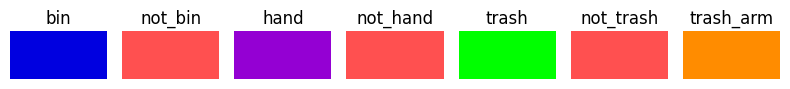

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Normalize RGB values to 0-1 range
def normalize_rgb(rgb_tuple):
    return tuple(x/255 for x in rgb_tuple)

# Turn colors into normalized RGB values for matplotlib
colors_and_labels_rgb = [(key, normalize_rgb(value)) for key, value in colour_palette.items()]

# Create figure and axis
fig, ax = plt.subplots(1, 7, figsize=(8, 1))

# Flatten the axis array for easier iteration
ax = ax.flatten()

# Plot each color square
for idx, (label, color) in enumerate(colors_and_labels_rgb):
    ax[idx].add_patch(plt.Rectangle(xy=(0, 0),
                                    width=1,
                                    height=1,
                                    facecolor=color))
    ax[idx].set_title(label)
    ax[idx].set_xlim(0, 1)
    ax[idx].set_ylim(0, 1)
    ax[idx].axis('off')

plt.tight_layout()
plt.show()